In [1]:
import numpy as np
import pandas as pd

import cvxopt
import yfinance as yf
import pandas_datareader

from datetime import datetime
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn') # style.use('ggplot') # style.use('fivethirtyeight')
%matplotlib inline

# Sharpe-Ratio Maximize Model

In [2]:
df_topix30 = pd.read_csv("../data/tse_topixcore30_20131031.csv")
df_topix30.head()

,日付,コード,銘柄名,市場・商品区分,33業種コード,33業種区分,17業種コード,17業種区分,規模コード,規模区分
0,20201030,2914,日本たばこ産業,市場第一部（内国株）,3050,食料品,1,食品,2,TOPIX Large70
1,20201030,3382,セブン＆アイ・ホールディングス,市場第一部（内国株）,6100,小売業,14,小売,1,TOPIX Core30
2,20201030,4063,信越化学工業,市場第一部（内国株）,3200,化学,4,素材・化学,1,TOPIX Core30
3,20201030,4452,花王,市場第一部（内国株）,3200,化学,4,素材・化学,1,TOPIX Core30
4,20201030,4502,武田薬品工業,市場第一部（内国株）,3250,医薬品,5,医薬品,1,TOPIX Core30


In [3]:
stocks_topix30 = df_topix30['コード'].values
stocks_topix30

array([2914, 3382, 4063, 4452, 4502, 4503, 5401, 6301, 6501, 6502, 6752,
       6758, 6954, 7201, 7203, 7267, 7751, 8031, 8058, 8306, 8316, 8411,
       8604, 8766, 8802, 9021, 9432, 9433, 9437, 9984])

In [4]:
st = '2013/10/31' # st = datetime(2013, 10, 31)
ed = '2018/10/31' # ed = datetime(2018, 10, 31)

symbols =  [str(s)+'.T' for s in stocks_topix30]
# symbols.append('^N225')
# symbols.append('TOPIX')

dfs = []
for symbol in symbols:
    df = pandas_datareader.data.DataReader(symbol, 'yahoo', st, ed) # daily
    df = df.resample('M').mean() # daily -> monthly
    df = df.sort_values(by='Date', ascending=True)
    df = df.fillna(method='ffill') # 1つ前の行の値で埋める
    df = df[['Close']].rename(columns={'Close': symbol})
    dfs.append(df)

df = pd.concat(dfs, axis=1)

In [5]:
display(df.head(5))
display(df.tail(5))

,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-31,3550.000000,3620.000000,5530.000000,3265.000000,4665.000000,1092.000000,3230.000000,2140.000000,3425.000000,4160.000000,...,4715.000000,2050.000000,723.000000,3205.000000,2797.000000,4395.000000,1272.500000,1770.000000,1560.000000,3650.000000
2013-11-30,3563.250000,3676.000000,5811.000000,3321.250000,4799.250000,1186.800000,3278.000000,2140.100000,3524.750000,4193.000000,...,4964.750000,2127.000000,770.250000,3314.000000,2820.400000,4439.500000,1295.000000,1999.500000,1592.150000,3923.250000
2013-12-31,3444.750000,3880.250000,5927.000000,3287.000000,5037.750000,1204.800000,3354.500000,2077.700000,3803.250000,4311.000000,...,5136.750000,2140.000000,785.100000,3389.750000,2881.500000,4446.250000,1341.125000,2109.166998,1664.750000,4418.750000
2014-01-31,3204.105263,4245.578947,5829.210526,3304.736842,4816.000000,1241.789467,3321.578947,2082.631579,4157.631579,4735.263158,...,5230.210526,2295.789474,785.157895,3269.368421,2859.000000,4423.578947,1410.960526,2064.000508,1705.631579,4277.605263
2014-02-28,3267.894737,3912.789474,5658.315789,3298.894737,4771.578947,1254.557887,3017.368421,2091.473684,3969.210526,4299.473684,...,4708.684211,2122.631579,695.105263,3044.105263,2494.052632,4173.210526,1391.789474,1912.403147,1640.421053,3798.210526


,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,3075.666667,4882.523810,10511.666667,8450.714286,4377.476190,1731.714286,2242.214286,3326.857143,4002.666667,3247.142857,...,4458.857143,1904.285714,558.900004,5410.428571,1976.142857,8058.571429,2584.880952,3016.500000,2832.880952,4072.952381
2018-07-31,3023.750000,4582.818182,10456.727273,8204.318182,4658.227273,1776.159091,2146.227273,3218.454545,3924.227273,3445.909091,...,4344.181818,1906.500000,540.600003,5275.590909,1915.886364,7857.727273,2536.500000,3103.318182,2843.681818,4556.977273
2018-08-31,3047.347826,4544.652174,10762.391304,8234.347826,4651.478261,1869.869565,2257.630435,3128.913043,3705.391304,3308.695652,...,4385.260870,1951.869565,512.460866,5292.260870,1818.065217,7569.782609,2569.130435,3044.195652,2912.108696,4996.978261
2018-09-30,2935.325000,4851.200000,9800.750000,8830.600000,4661.800000,1912.075000,2249.325000,3215.550000,3686.150000,3251.500000,...,4459.350000,1964.800000,528.365002,5335.550000,1858.675000,7637.600000,2507.425000,3035.600000,2962.325000,5318.400000
2018-10-31,2923.586957,4917.173913,9283.913043,8286.478261,4547.565217,1865.630435,2233.326087,3140.521739,3524.826087,3290.652174,...,4472.695652,1940.086957,545.647827,5427.869565,1835.565217,7600.347826,2477.434783,2944.304348,2918.391304,4923.630435


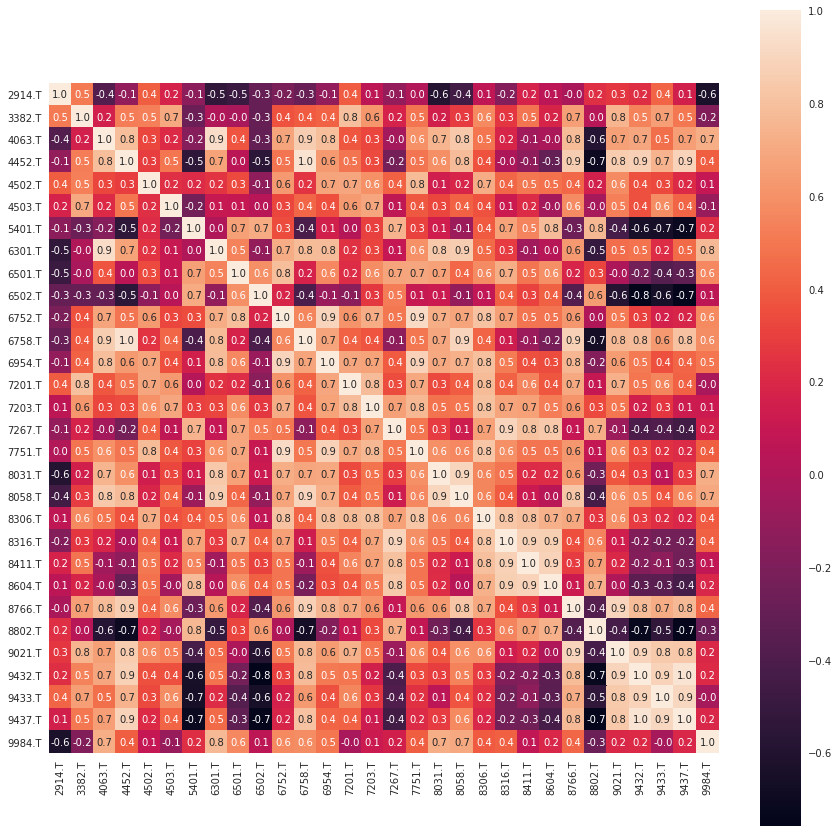

In [6]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.1f')
plt.show()

In [7]:
def calc_returns(df):
    """
    calculate change ratio of returns && cumulative returns
    """
    # df = df.fillna(method='ffill')

    # 収益率(returns change)
    df_retchg = df.pct_change()
    df_retchg[:1] = 0.0 # 最初の行を0.0に直す
    
    # 累積収益率 (cumulative returns)
    df_retcum = (1 + df_retchg).cumprod()
    df_retcum[:1] = 1.0 # 最初の行を1.0に直す
    
    return df_retcum, df_retchg

In [8]:
df_retcum, df_retchg = calc_returns(df)

display(df_retchg.head(3))
display(df_retchg.tail(3))

display(df_retcum.head(3))
display(df_retcum.tail(3))

,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-11-30,0.003732,0.015470,0.050814,0.017228,0.028778,0.086813,0.014861,0.000047,0.029124,0.007933,...,0.052969,0.037561,0.065353,0.034009,0.008366,0.010125,0.017682,0.129661,0.020609,0.074863
2013-12-31,-0.033256,0.055563,0.019962,-0.010312,0.049695,0.015167,0.023337,-0.029158,0.079013,0.028142,...,0.034644,0.006112,0.019279,0.022858,0.021664,0.001520,0.035618,0.054847,0.045599,0.126298


,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-31,0.007804,-0.008328,0.029231,0.003660,-0.001449,0.052760,0.051907,-0.027821,-0.055765,-0.039819,...,0.009456,0.023797,-0.052052,0.003160,-0.051058,-0.036645,0.012864,-0.019051,0.024063,0.096555
2018-09-30,-0.036761,0.067452,-0.089352,0.072410,0.002219,0.022571,-0.003679,0.027689,-0.005193,-0.017286,...,0.016895,0.006625,0.031035,0.008180,0.022337,0.008959,-0.024018,-0.002824,0.017244,0.064323
2018-10-31,-0.003999,0.013600,-0.052734,-0.061618,-0.024504,-0.024290,-0.007113,-0.023333,-0.043765,0.012041,...,0.002993,-0.012578,0.032710,0.017303,-0.012433,-0.004877,-0.011961,-0.030075,-0.014831,-0.074227


,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2013-11-30,1.003732,1.015470,1.050814,1.017228,1.028778,1.086813,1.014861,1.000047,1.029124,1.007933,...,1.052969,1.037561,1.065353,1.034009,1.008366,1.010125,1.017682,1.129661,1.020609,1.074863
2013-12-31,0.970352,1.071892,1.071790,1.006738,1.079904,1.103297,1.038545,0.970888,1.110438,1.036298,...,1.089449,1.043902,1.085892,1.057644,1.030211,1.011661,1.053929,1.191620,1.067147,1.210616


,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-31,0.858408,1.255429,1.946183,2.522005,0.997101,1.712335,0.698957,1.462109,1.081866,0.795360,...,0.930066,0.952131,0.708798,1.651251,0.650005,1.722362,2.018963,1.719885,1.866736,1.369035
2018-09-30,0.826852,1.340110,1.772288,2.704625,0.999314,1.750984,0.696385,1.502593,1.076248,0.781611,...,0.945779,0.958439,0.730795,1.664758,0.664524,1.737793,1.970472,1.715028,1.898926,1.457096
2018-10-31,0.823546,1.358335,1.678827,2.537972,0.974826,1.708453,0.691432,1.467534,1.029146,0.791022,...,0.948610,0.946384,0.754700,1.693563,0.656262,1.729317,1.946904,1.663449,1.870764,1.348940


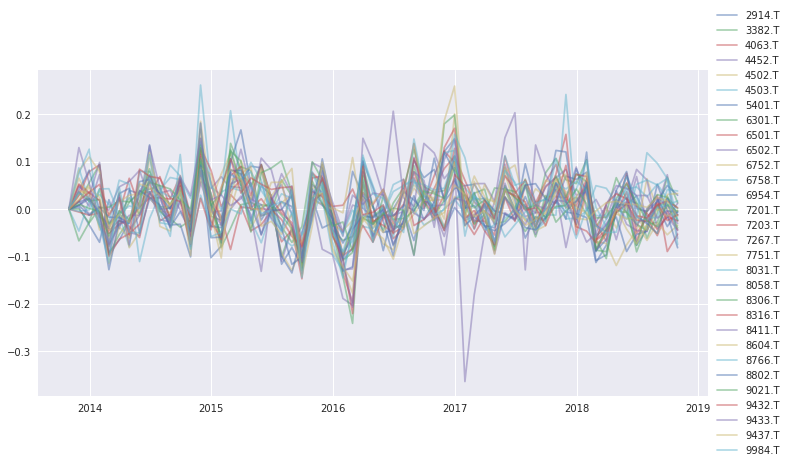

In [9]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retchg.index, df_retchg[col], label=col, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

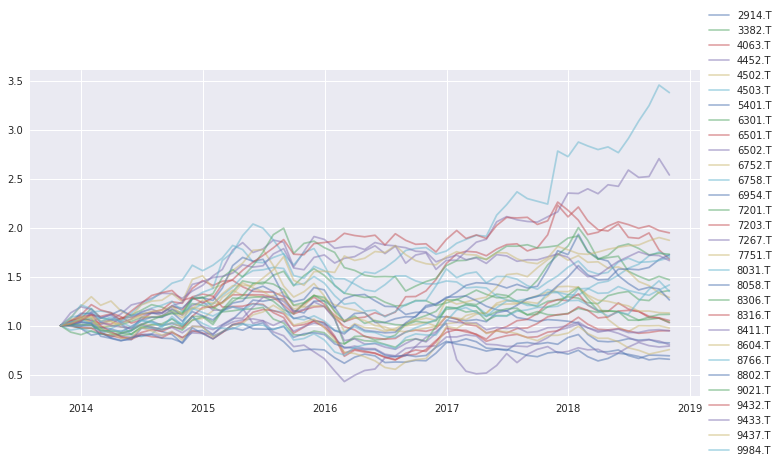

In [10]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retcum.index, df_retcum[col], label=col, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

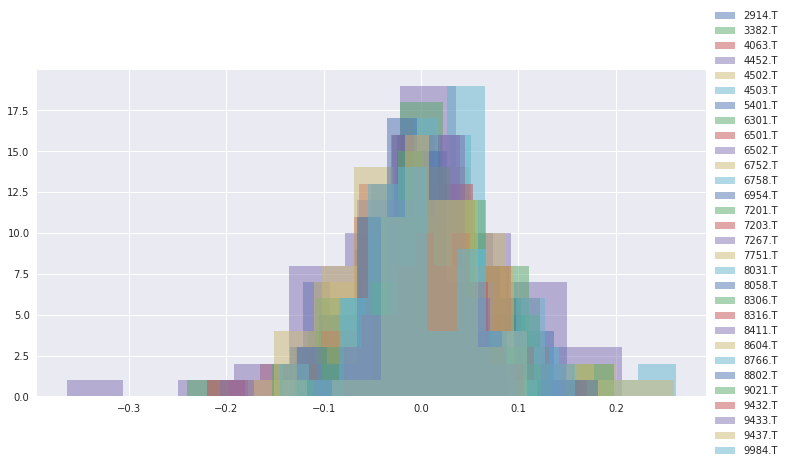

In [11]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.hist(df_retchg[[col]], label=col, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

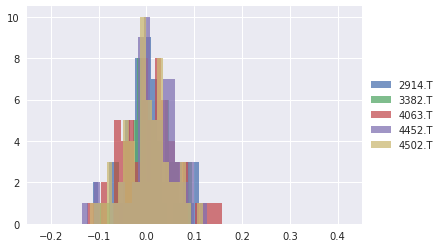

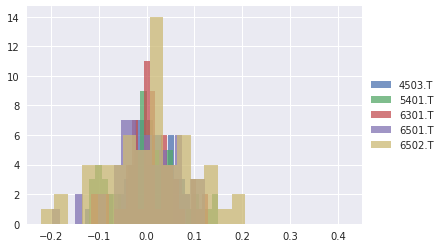

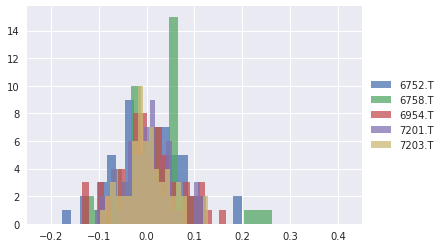

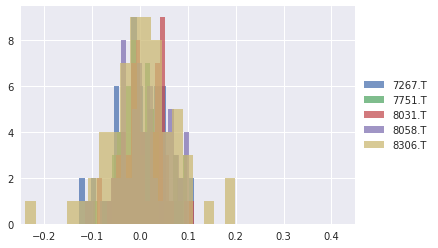

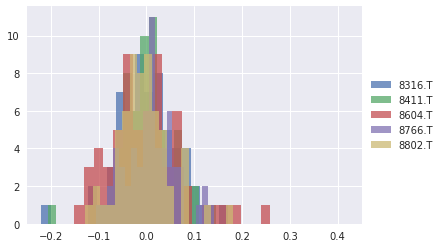

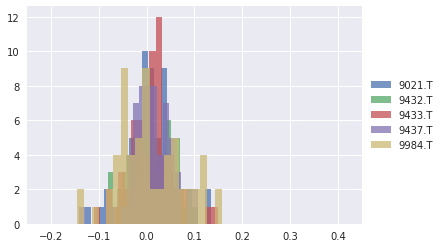

In [12]:
for idx, col in enumerate(df.columns):
    plt.hist(df_retchg[[col]].values, bins=20, label=col, alpha=0.75)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlim([-0.25, 0.45])
    if (idx + 1) % 5 == 0:
        plt.show()

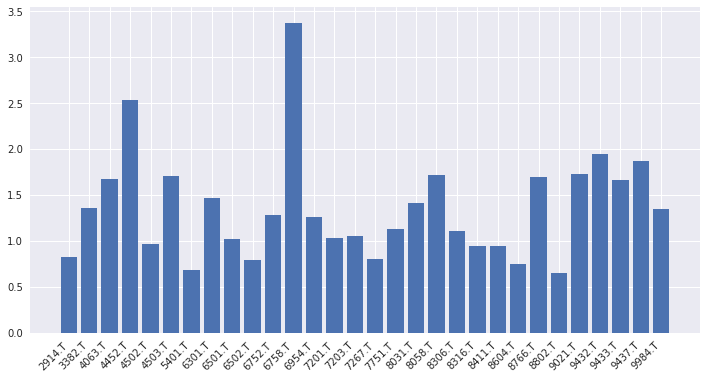

In [13]:
# cumulative returns
plt.figure(figsize=(12,6))
plt.bar(df_retchg.columns, df_retcum.iloc[-1].values)
plt.xticks(rotation=45, ha='right')
plt.show()

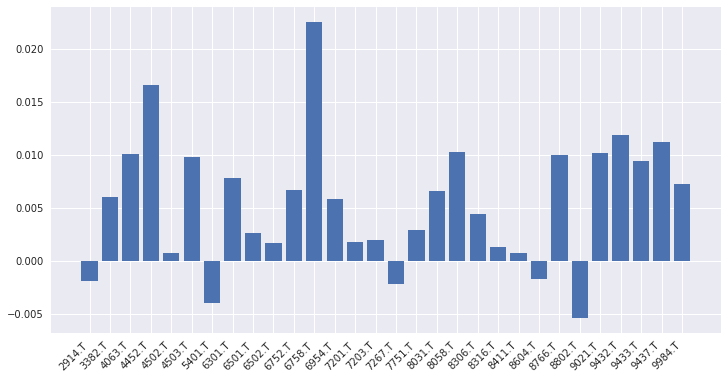

In [14]:
# expected returns
plt.figure(figsize=(12,6))
plt.bar(df_retcum.columns, df_retchg.mean().values)
plt.xticks(rotation=45, ha='right')
plt.show()

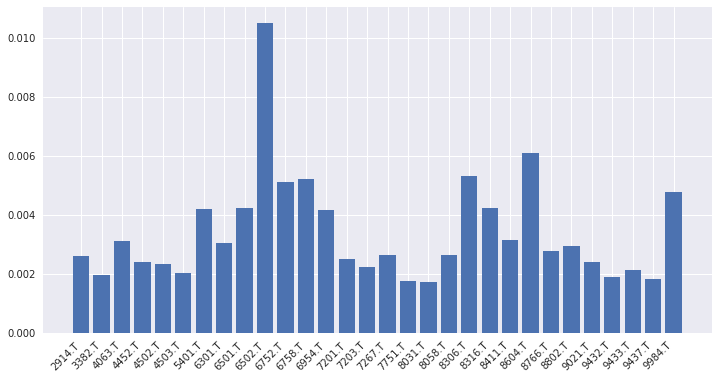

In [15]:
# variance
plt.figure(figsize=(12,6))
plt.bar(df_retcum.columns, df_retchg.var().values)
plt.xticks(rotation=45, ha='right')
plt.show()

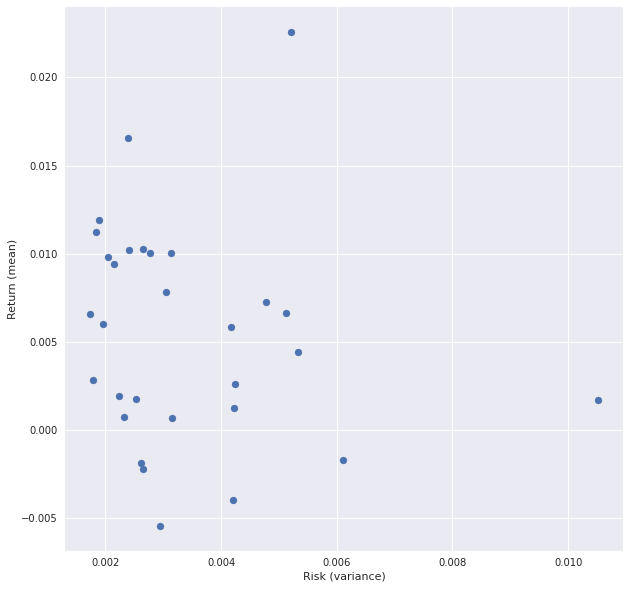

In [16]:
# returns vs risk (change)
plt.figure(figsize=(10,10))
mean = df_retchg.mean().values
var = df_retchg.var().values
plt.scatter(var, mean)
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

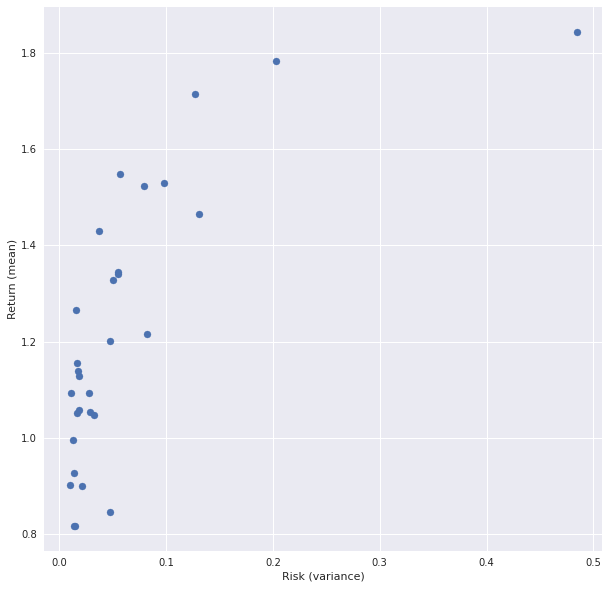

In [17]:
# returns vs risk (cumulative)
plt.figure(figsize=(10,10))
mean = df_retcum.mean().values
var = df_retcum.var().values
plt.scatter(var, mean)
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

### ポートフォリオ選択モデル

**シャープレシオ最大化モデル**

シャープレシオ(Sharpe ratio, SR)は，最もよく使われるポートフォリオに対するリスク調整済みパフォーマンス尺度である．あるポートフォリオのシャープレシオ${\theta}_p$は，無リスク資産の収益率$r_f$とポートフォリオの期待収益率$\bar{r}_p$，ポートフォリオの標準偏差$\sigma_p$を用いて
\begin{align}
    {\theta}_p := \frac{\bar{r}_p - r_f}{\sigma_p}
\end{align}
と定義される．シャープレシオ最大化問題は，
目的関数に$n$コの資産間の共分散行列が含まれるため，二次計画問題(Quadratic Programming, QP)のクラスとなり，次のように定式化される．

\begin{align}
    \underset{\bf x \in \mathcal{X}}{\rm maximize} ~~~ 
    &\frac{\bar{r}_p - r_f}{\sigma_p}
    \left( 
    = \frac{\bar{\bf r}^{\mathrm{T}} {\bf x} - r_f}{\sqrt{{\bf x}^{\mathrm{T}} \Sigma {\bf x}}}
    \right) \\
    {\rm subject~to} ~~~ 
    &{\| {\bf x} \|}_{1} = \sum_{i=1}^{n} x_i = 1 \\
    &x_i \geq 0 ~~ (i = 1, \cdots, n)
\end{align}


- $\Sigma \in \mathbb{R}^{n \times n}$ - $n$コの資産の共分散行列
- ${\bf x} \in \mathbb{R}^{n}$ - $n$コの資産の投資比率ベクトル
- $\bar{\bf r} \in \mathbb{R}^{n}$ - $n$コの資産の期待収益率ベクトル
- $x_i \in \mathbb{R}$ - 資産$i$の投資比率
- $\bar{r}_i \in \mathbb{R}$ - 資産$i$の期待収益率
- $r_f \in \mathbb{R}$ - 無リスク資産の収益率
- $\bar{r}_p \in \mathbb{R}$ - ポートフォリオの期待収益率
- $\sigma_p \in \mathbb{R}$ - ポートフォリオの標準偏差 

この最適化問題の目的関数を二次形式で表すため，リスクプレミアム$\lambda$と各資産の比重ベクトル${\bf w} = {\bf x} / \lambda$を導入して変形すると，次のようにSharpe-ratio最大化問題のコンパクト分解表現を得る．

\begin{align}
    \underset{\bf w \in \mathcal{W}}{\rm minimize} ~~~ 
    & {\bf w}^{\mathrm{T}} \Sigma {\bf w} \\
    {\rm subject~to} ~~~ 
    &{\| \hat{\bf r}^{\mathrm{T}} {\bf w} \|}_{1} = \sum_{i=1}^{n} (\bar{r}_i - r_f) w_i = 1 \\
    &w_i \geq 0 ~~ (i = 1, \cdots, n)
\end{align}


- $x_i \in \mathbb{R}$ - 資産$i$の投資比率
- $w_i \in \mathbb{R}$ - 資産$i$の投資比率と期待リスクプレミアムの比率 ($w_i = x_i / \lambda $)
- $\lambda \in \mathbb{R}$ - ポートフォリオの期待リスクプレミアム ($\lambda = \sum_{i=1}^{n} \hat{r}_i x_i = \sum_{i=1}^{n} (\bar{r}_i - r_f) x_i$)
- $\hat{r}_i \in \mathbb{R}$ - 資産$i$の期待リスクプレミアム ($\hat{r}_i = \bar{r}_i - r_f$)


**二次計画問題**

Pythonの凸最適化向けパッケージ[CVXOPT](https://cvxopt.org)を使って，二次計画問題(QP)を解く．
CVXOPTで二次計画問題を扱う場合は，解きたい最適化問題を以下の一般化されたフォーマットに整理して，

\begin{align}
\underset{\bf x}{\rm minimize} ~~~ &\frac{1}{2} {\bf x}^{T} P {\bf x} + {\bf q}^{T} {\bf x} \\\
{\rm subject~to} ~~~ & G {\bf x} \leq {\bf h} \\\
&A {\bf x} = {\bf b}
\end{align}

パラメータ$P,q,G,h,A$を計算し，[cvxopt.solvers.qp()](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)関数を実行することで最適解と最適値を求める．シャープレシオ最大化モデルの場合は次のようになる．

\begin{align}
    P = 2 \cdot \Sigma, \hspace{1em}
    q = {\bf 0}_n, \hspace{1em}
    G = -1 \cdot
        \begin{pmatrix}
            1 & \cdots & 0 \\
            \vdots & \ddots & \vdots \\
            0 & \cdots & 1 
        \end{pmatrix}, \hspace{1em}
    h = {\bf 0}_n, \hspace{1em}
    A = {\left(
            \begin{array}{c}
              \bar{r}_1 - r_f \\
              \vdots \\
              \bar{r}_n - r_f
            \end{array}
        \right)}^{T}, \hspace{1em}
    b = 1
\end{align}



参考:
- https://cvxopt.org/userguide/coneprog.html
- https://qiita.com/ryoshi81/items/8b0c6add3e367f94c828

In [18]:
import cvxopt

def cvxopt_qp_solver(r, r_f, cov):
    # CVXOPT QP Solver for Markowitz' Mean-Variance Model
    # See https://cvxopt.org/userguide/coneprog.html#quadratic-programming
    # See https://cdn.hackaday.io/files/277521187341568/art-mpt.pdf
    n = len(r)
    # r_hat = cvxopt.matrix((r - r_f).reshape(1, n))
        
    # Create Objective matrices
    P = cvxopt.matrix(2.0 * np.array(cov))
    q = cvxopt.matrix(np.zeros((n, 1)))
    
    # Create constraint matrices
    G = cvxopt.matrix(-np.eye(n))
    h = cvxopt.matrix(np.zeros((n, 1)))
    # A = cvxopt.matrix(r_hat)
    A = cvxopt.matrix((r - r_f).reshape(1, n))
    b = cvxopt.matrix(1.0)
    
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    return sol

In [19]:
r = df_retchg.mean().values
r_f = 0.0001
cov = np.array(df_retcum.cov())

sol = cvxopt_qp_solver(r, r_f, cov)
w_opt = np.squeeze(np.array(sol['x']))
x_opt = w_opt / np.linalg.norm(w_opt, ord=1)


print(x_opt)
print("r_f           :", r_f)

     pcost       dcost       gap    pres   dres
 0:  4.0684e+02  1.5750e+02  2e+03  3e+01  6e+01
 1:  3.3050e+02 -1.1993e+00  5e+02  6e+00  1e+01
 2:  2.4050e+02  1.3031e+02  1e+02  8e-01  1e+00
 3:  1.8234e+02  1.5701e+02  3e+01  1e-14  5e-15
 4:  1.6572e+02  1.6443e+02  1e+00  4e-15  5e-15
 5:  1.6469e+02  1.6466e+02  3e-02  1e-14  5e-15
 6:  1.6468e+02  1.6468e+02  3e-04  8e-15  3e-15
 7:  1.6468e+02  1.6468e+02  3e-06  1e-14  4e-15
Optimal solution found.
[2.60081537e-09 3.30363921e-01 1.55014821e-10 1.22350979e-10
 4.53725187e-10 5.15869525e-09 2.88878116e-10 2.54995113e-10
 3.47984554e-10 2.62349185e-01 1.86605577e-10 5.60081096e-11
 2.15721088e-10 4.30125369e-10 2.64457545e-10 2.62133293e-10
 3.42345443e-10 1.68477099e-09 3.04569655e-10 2.81125071e-10
 3.58049215e-10 4.35266088e-10 3.05298464e-10 2.28364017e-10
 2.36346730e-10 2.09849498e-10 6.49153855e-10 2.14060300e-02
 1.73643745e-01 2.12237104e-01]
r_f           : 0.0001


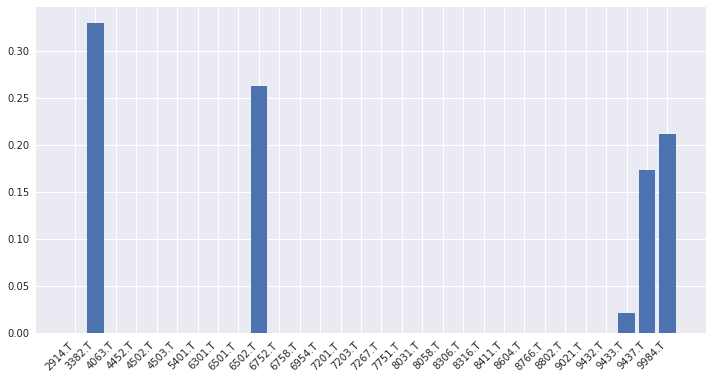

In [20]:
# Opt portfolio
plt.figure(figsize=(12,6))
plt.bar(df.columns, x_opt)
plt.xticks(rotation=45, ha='right')
plt.show()

In [21]:
meanchg = df_retchg.mean().values
meanchg_opt = float(np.dot(meanchg, x_opt))

meancum = df_retcum.iloc[-1].values
meancum_opt = float(np.dot(meancum, x_opt))

varchg = df_retchg.var().values
varchg_opt = float(np.dot(varchg, x_opt ** 2))

varcum = df_retcum.var().values
varcum_opt = float(np.dot(varcum, x_opt ** 2))

print("opt portfolio\n=============")
print("mean chg :", meanchg_opt)
print("var chg  :", varchg_opt)
print("mean cum :", meancum_opt)
print("var cum  :", varcum_opt)

opt portfolio
mean chg : 0.006113726524595774
var chg  : 0.0012081831637767724
mean cum : 1.3030183540478926
var cum  : 0.008728508411410645


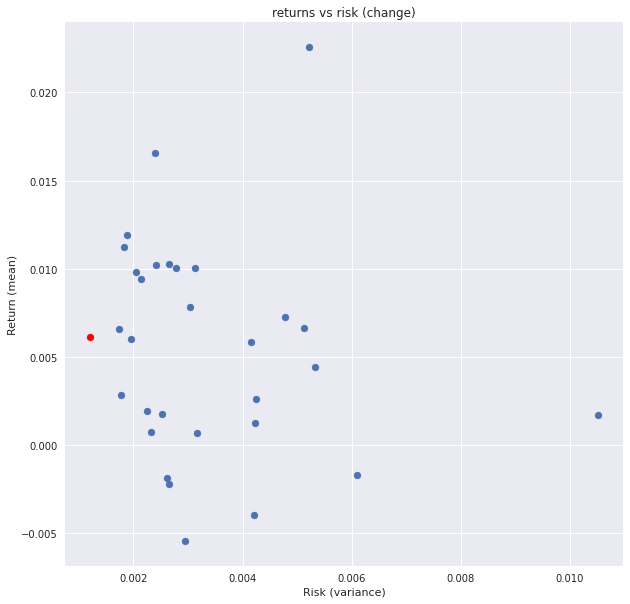

In [22]:
# returns vs risk (change)
plt.figure(figsize=(10,10))
plt.scatter(varchg, meanchg)
plt.scatter(varchg_opt, meanchg_opt, marker="o", color="red")
plt.title("returns vs risk (change)")
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

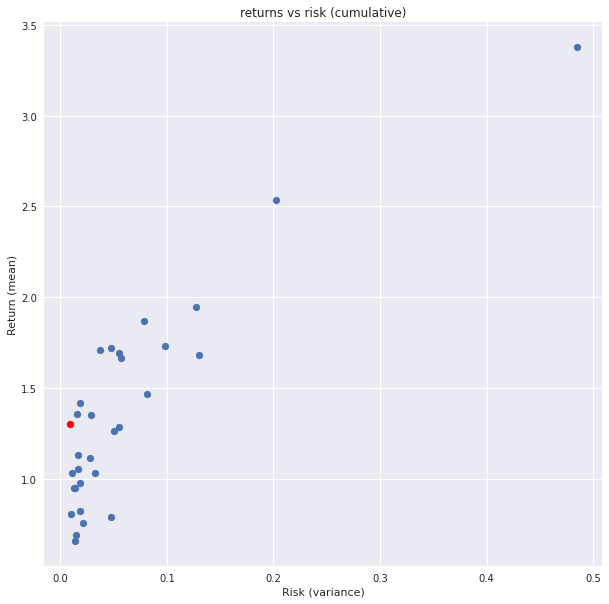

In [23]:
# returns vs risk (cumulative)
plt.figure(figsize=(10,10))
plt.scatter(varcum, meancum)
plt.scatter(varcum_opt, meancum_opt, marker="o", color="red")
plt.title("returns vs risk (cumulative)")
plt.xlabel("Risk (variance)")
plt.ylabel("Return (mean)")
plt.show()

# Backtest

to evaluate the Sharpe-ratio performance of the given portfolio

In [24]:
class SharpeRatioMaxModel():
    
    def __init__(self, df, window_size, rebalance_freq, r_f=None):
        """
        Args:
        =====
        - df: pandas.dataframe
            panel data for target assets for the portfolio. 
                its index must be `numpy.datetime64` type.
                its columns must be time-series data of target assets.
        - window_size: int
            the size of time-window which is used when deriving (or updating) the portfolio.
        - rebalance_freq: int
            rebalance frequency of the portfolio.
        - r_f: float
            rate of returns of the risk-free asset.
        """
        self.df = df
        self.df_chg = df.pct_change()
        self.df_chg[:1] = 0.0 # set 0.0 to the first record
        self.df_bt = None
        self.window_size = window_size
        self.rebalance_freq = rebalance_freq
        self.jgb_int = 0.0001 # 0.01% per year (Japanese Government Bond)
        self.r_f = r_f if r_f is not None else self.jgb_int * (1/12) # adjust monthly
        
    def backtest(self):
        date_init = self.df.index.values[self.window_size]
        df_bt = pd.DataFrame([[0.0, np.nan]], index=[date_init], columns=['ror', 'std'])
        for idx, date in enumerate(self.df.index.values):
            if idx >= self.window_size + self.rebalance_freq:
                if (idx - self.window_size) % self.rebalance_freq == 0:
                    # df_chg_train
                    st = idx - self.rebalance_freq - self.window_size
                    ed = idx - self.rebalance_freq
                    df_chg_train = self.df_chg[st:ed]
                    
                    # x_p: min variance portfolio
                    x_p = self.calc_portfolio(df_chg_train, self.r_f)
                    
                    # df_chg_test
                    st = idx - self.rebalance_freq
                    ed = idx
                    df_chg_test = self.df_chg[st:ed]
                    df_chgcum_test = (1.0 + df_chg_test).cumprod() - 1.0
                                                            
                    # ror_p: rate of return (portfolio)
                    ror_test = df_chgcum_test.iloc[-1].values
                    ror_p = float(np.dot(ror_test, x_p))
                    
                    # std (portfolio)
                    if self.rebalance_freq == 1:
                        std_p = np.nan
                    else:
                        std_test = df_chg_test.std(ddof=True).values
                        std_p = float(np.dot(std_test, np.abs(x_p)))

                    # append
                    df_one = pd.DataFrame([[ror_p, std_p]], index=[date], columns=df_bt.columns)                    
                    df_bt = df_bt.append(df_one)
        self.df_bt = df_bt
        return df_bt

    def calc_portfolio(self, df_retchg, r_f): 
        """ portfolio (sharpe-ratio max model) """
        r = df_retchg.mean().values
        cov = np.array(df_retchg.cov())
        x_opt = self.cvxopt_qp_solver(r, r_f, cov)
        return x_opt
        
    def cvxopt_qp_solver(self, r, r_f, cov):
        """
        CVXOPT QP Solver for Markowitz' Mean-Variance Model
        - See also https://cvxopt.org/userguide/coneprog.html#quadratic-programming
        - See also https://cdn.hackaday.io/files/277521187341568/art-mpt.pdf
        
        r: mean returns of target assets. (vector)
        r_f: rate of returns of the risk-free asset.
        cov: covariance matrix of target assets. (matrix)
        """
        n = len(r)

        # Create Objective matrices
        P = cvxopt.matrix(2.0 * np.array(cov))
        q = cvxopt.matrix(np.zeros((n, 1)))

        # Create constraint matrices
        G = cvxopt.matrix(-np.eye(n))
        h = cvxopt.matrix(np.zeros((n, 1)))
        A = cvxopt.matrix((r - r_f).reshape(1, n))
        b = cvxopt.matrix(1.0)
        
        # stop log messages
        cvxopt.solvers.options['show_progress'] = False
        
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        w_opt = np.squeeze(np.array(sol['x']))
        x_opt = w_opt / np.linalg.norm(w_opt, ord=1)
        return x_opt
    
    def calc_returns(self, df):
        # Rate of returns
        df_retchg = df.pct_change()
        df_retchg[:1] = 0.0 # set 0.0 to the first record
        
        # Cumulative returns)
        df_retcum = (1.0 + df_retchg).cumprod() - 1.0
        df_retcum[:1] = 0.0 # set 0.0 to the first record
        
        return df_retcum, df_retchg
    
    def evaluate_backtest(self, logging=False):   
        if self.df_bt is None:
            pass
        else:
            self.r_mean = self.df_bt["ror"].mean()
            self.r_std = self.df_bt["ror"].std(ddof=True)
            self.sharpe_ratio = (self.r_mean - self.r_f) / self.r_std
            self.net_capgain = (self.df_bt["ror"] + 1.0).cumprod().iloc[-1] - 1.0
            
            self.r_mean_peryear = 12 * self.r_mean
            self.r_std_peryear = np.sqrt(12) * self.r_std
            self.sharpe_ratio_peryear = (self.r_mean_peryear - self.jgb_int) / self.r_std_peryear

            if logging:
                print("Portfolio Performance")
                print("=======================")
                print("Returns per month")
                print("  sharpe ratio     : {:.8f}".format(self.sharpe_ratio))
                print("  mean of returns  : {:.8f}".format(self.r_mean))
                print("  std of returns   : {:.8f}".format(self.r_std))
                print("    risk-free rate : {:.8f}".format(self.r_f))
                print("    capgain ratio  : {:.8f}".format(self.net_capgain))
                print("Returns per year")
                print("  sharpe ratio     : {:.8f}".format(self.sharpe_ratio_peryear))
                print("  mean of returns  : {:.8f}".format(self.r_mean_peryear))
                print("  std of returns   : {:.8f}".format(self.r_std_peryear))
                
            
    def plot_returns(self):
        if self.df_bt is None:
            pass
        else:
            plt.figure(figsize=(12,6))
            plt.plot(self.df_bt.index.values, self.df_bt["ror"].values, label="rate of returns")
            plt.plot(self.df_bt.index.values, self.df_bt["ror"].cumsum().values, label="total capital gain ratio")
            plt.legend(loc="upper left")
            plt.show()

In [25]:
df_topix30 = pd.read_csv("../data/tse_topixcore30_20131031.csv")

stocks_topix30 = df_topix30['コード'].values
symbols =  [str(s)+'.T' for s in stocks_topix30]

st = '2013/10/31' # st = datetime(2013, 10, 30)
ed = '2018/10/31' # ed = datetime(2018, 10, 30)

dfs = []
for symbol in symbols:
    df = pandas_datareader.data.DataReader(symbol, 'yahoo', st, ed) # daily
    df = df.resample('M').mean() # daily -> monthly
    df = df.sort_values(by='Date', ascending=True)
    df = df.fillna(method='ffill') # 1つ前の行の値で埋める
    df = df[['Close']].rename(columns={'Close': symbol})
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df.head()

,2914.T,3382.T,4063.T,4452.T,4502.T,4503.T,5401.T,6301.T,6501.T,6502.T,...,8316.T,8411.T,8604.T,8766.T,8802.T,9021.T,9432.T,9433.T,9437.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-31,3550.000000,3620.000000,5530.000000,3265.000000,4665.000000,1092.000000,3230.000000,2140.000000,3425.000000,4160.000000,...,4715.000000,2050.000000,723.000000,3205.000000,2797.000000,4395.000000,1272.500000,1770.000000,1560.000000,3650.000000
2013-11-30,3563.250000,3676.000000,5811.000000,3321.250000,4799.250000,1186.800000,3278.000000,2140.100000,3524.750000,4193.000000,...,4964.750000,2127.000000,770.250000,3314.000000,2820.400000,4439.500000,1295.000000,1999.500000,1592.150000,3923.250000
2013-12-31,3444.750000,3880.250000,5927.000000,3287.000000,5037.750000,1204.800000,3354.500000,2077.700000,3803.250000,4311.000000,...,5136.750000,2140.000000,785.100000,3389.750000,2881.500000,4446.250000,1341.125000,2109.166998,1664.750000,4418.750000
2014-01-31,3204.105263,4245.578947,5829.210526,3304.736842,4816.000000,1241.789467,3321.578947,2082.631579,4157.631579,4735.263158,...,5230.210526,2295.789474,785.157895,3269.368421,2859.000000,4423.578947,1410.960526,2064.000508,1705.631579,4277.605263
2014-02-28,3267.894737,3912.789474,5658.315789,3298.894737,4771.578947,1254.557887,3017.368421,2091.473684,3969.210526,4299.473684,...,4708.684211,2122.631579,695.105263,3044.105263,2494.052632,4173.210526,1391.789474,1912.403147,1640.421053,3798.210526


In [26]:
# Risk-free rate (10Year-JGB, monthly interest)
r_f = (1 + 0.0001) ** (1/12) - 1.0 

srmm = SharpeRatioMaxModel(df, 
                    window_size=12,
                    rebalance_freq=3, 
                    r_f=r_f)

In [27]:
df_backtest = srmm.backtest()
display(df_backtest)

,ror,std
2014-10-31,0.000000,NaN
2015-01-31,0.000503,0.052960
2015-04-30,0.207746,0.037374
2015-07-31,-0.044771,0.037580
2015-10-31,-0.029738,0.100741
2016-01-31,0.035284,0.047394
2016-04-30,0.037385,0.027717
2016-07-31,-0.050150,0.031337
2016-10-31,-0.047784,0.049337
2017-01-31,0.098763,0.039144


In [28]:
interest_jgb = 0.0001 # 0.01% per year

r_mean = df_backtest["ror"].mean()
r_std = df_backtest["ror"].std() * (len(df_backtest)) / (len(df_backtest)-1)
r_f = (1 + interest_jgb) ** (1/12) - 1.0 
sharpe_ratio = (r_mean - r_f) / r_std
net_capgain = (df_backtest["ror"] + 1.0).cumprod().iloc[-1] - 1.0

print("Portfolio Performance")
print("=====================")
print("mean of returns : {:.8f}".format(r_mean))
print("std of returns  : {:.8f}".format(r_std))
print("risk-free rate  : {:.8f}".format(r_f))
print("sharpe ratio    : {:.8f}".format(sharpe_ratio))
print("capgain ratio   : {:.8f}".format(net_capgain))

Portfolio Performance
mean of returns : 0.02816963
std of returns  : 0.08461655
risk-free rate  : 0.00000833
sharpe ratio    : 0.33281072
capgain ratio   : 0.53002079


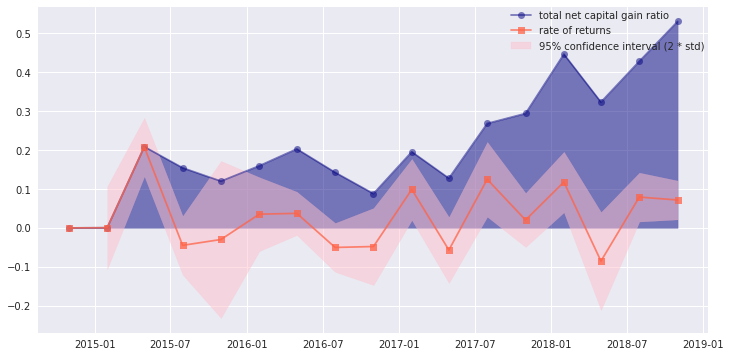

In [29]:
fig, ax = plt.subplots(figsize=(12,6))

# ror cum
x = df_backtest.index.values
y = (df_backtest["ror"] + 1.0).cumprod() - 1.0
ymin = np.zeros(len(y))
ymax = y
ax.fill_between(x, ymin, ymax, color="navy", alpha=0.5)
ax.plot(x, y, color="navy", marker="o", alpha=0.5, label="total net capital gain ratio")

# ror
y = df_backtest["ror"].values
ax.plot(x, y, color="tomato", alpha=0.75, marker="s", label="rate of returns")

# ror std
ymin = df_backtest["ror"].values - 2 * df_backtest["std"].values
ymax = df_backtest["ror"].values + 2 * df_backtest["std"].values
ax.fill_between(x, ymin, ymax, color="pink", alpha=0.5, label="95% confidence interval (2 * std)")

ax.legend(loc='upper right', borderaxespad=0.) 
plt.show()

Portfolio Performance
Returns per month
  sharpe ratio     : 0.35361139
  mean of returns  : 0.02816963
  std of returns   : 0.07963910
    risk-free rate : 0.00000833
    capgain ratio  : 0.53002079
Returns per year
  sharpe ratio     : 1.22494578
  mean of returns  : 0.33803553
  std of returns   : 0.27587795


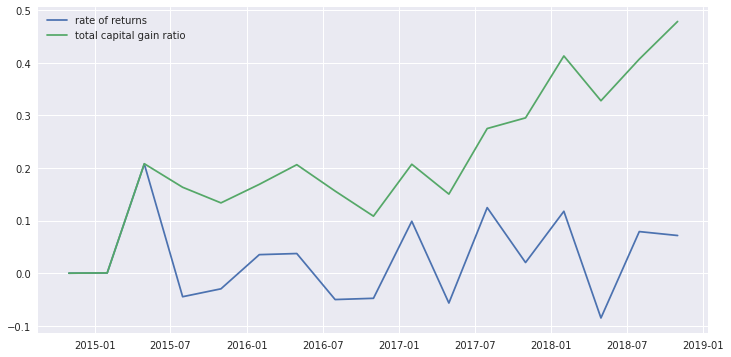

In [32]:
srmm.evaluate_backtest(logging=True)
srmm.plot_returns()

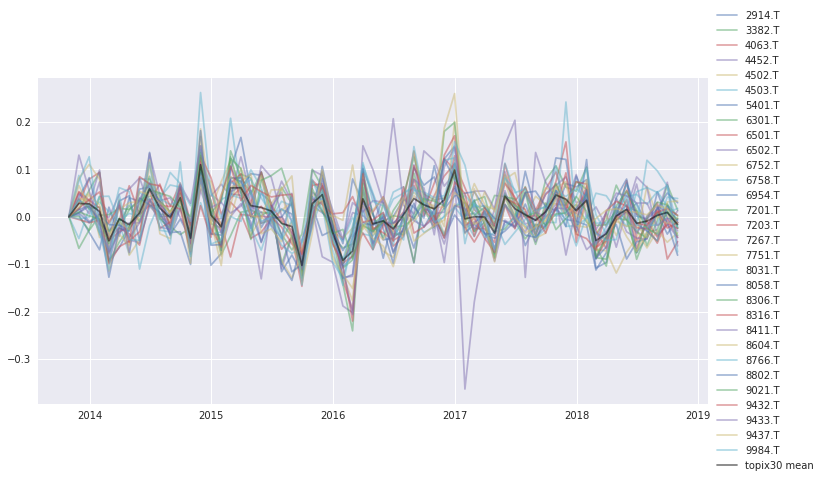

In [30]:
df_retchg = df.pct_change()
df_retchg[:1] = 0.0 # set 0.0 to the first record

plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retchg.index, df_retchg[col], label=col, alpha=0.5)
plt.plot(df_retchg.index, df_retchg.mean(axis='columns'), label="topix30 mean", color="black", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

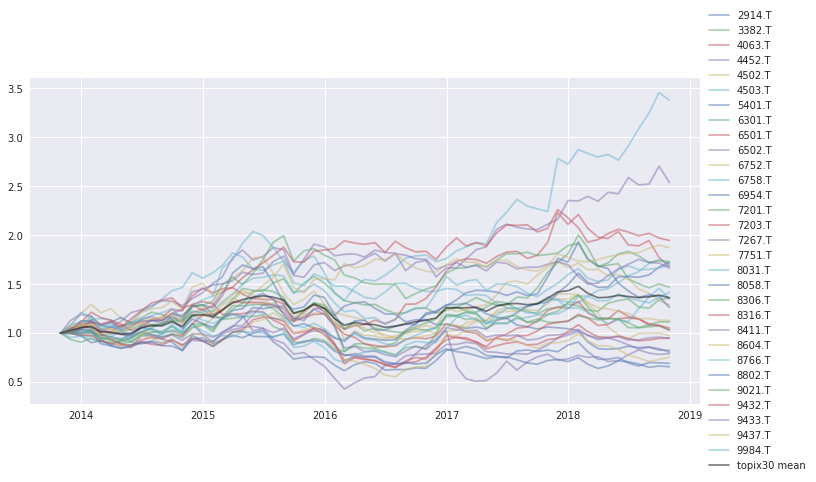

In [31]:
df_retcum = (1.0 + df_retchg).cumprod()
df_retcum[:1] = 1.0 # set 1.0 to the first record

plt.figure(figsize=(12, 6))
for idx, col in enumerate(df.columns):
    plt.plot(df_retcum.index, df_retcum[col], label=col, alpha=0.5)
plt.plot(df_retcum.index, df_retcum.mean(axis='columns'), label="topix30 mean", color="black", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()